<a href="https://colab.research.google.com/github/apoorvaec1030/Data-Science-projects/blob/main/NN_Tf_Twitter_Sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from utils import load_tweets, process_tweet

%matplotlib inline

[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Unzipping corpora/twitter_samples.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [2]:
# Load positive and negative tweets
all_positive_tweets, all_negative_tweets = load_tweets()

# View the total number of positive and negative tweets.
print(f"The number of positive tweets: {len(all_positive_tweets)}")
print(f"The number of negative tweets: {len(all_negative_tweets)}")

The number of positive tweets: 5000
The number of negative tweets: 5000


In [3]:
# Process all the tweets: tokenize the string, remove tickers, handles, punctuation and stopwords, stem the words
all_positive_tweets_processed = [process_tweet(tweet) for tweet in all_positive_tweets]
all_negative_tweets_processed = [process_tweet(tweet) for tweet in all_negative_tweets]

In [4]:
# Split positive set into validation and training
val_pos = all_positive_tweets_processed[4000:]
train_pos = all_positive_tweets_processed[:4000]
# Split negative set into validation and training
val_neg = all_negative_tweets_processed[4000:]
train_neg = all_negative_tweets_processed[:4000]

train_x = train_pos + train_neg
val_x  = val_pos + val_neg

# Set the labels for the training and validation set (1 for positive, 0 for negative)
train_y = [[1] for _ in train_pos] + [[0] for _ in train_neg]
val_y  = [[1] for _ in val_pos] + [[0] for _ in val_neg]

print(f"There are {len(train_x)} sentences for training.")
print(f"There are {len(train_y)} labels for training.\n")
print(f"There are {len(val_x)} sentences for validation.")
print(f"There are {len(val_y)} labels for validation.")

There are 8000 sentences for training.
There are 8000 labels for training.

There are 2000 sentences for validation.
There are 2000 labels for validation.


In [5]:
#  build_vocabulary
def build_vocabulary(corpus):
    '''Function that builds a vocabulary from the given corpus
    Input:
        - corpus (list): the corpus
    Output:
        - vocab (dict): Dictionary of all the words in the corpus.
                The keys are the words and the values are integers.
    '''

    # The vocabulary includes special tokens like padding token and token for unknown words
    # Keys are words and values are distinct integers (increasing by one from 0)
    vocab = {'': 0, '[UNK]': 1}


    count=2
    # For each tweet in the training set
    for tweet in corpus:
        # For each word in the tweet
        for word in tweet:
            # If the word is not in vocabulary yet, add it to vocabulary
            if word not in vocab:
                vocab[word]=count
                count+=1




    return vocab


vocab = build_vocabulary(train_x)
num_words = len(vocab)

print(f"Vocabulary contains {num_words} words\n")
print(vocab)

Vocabulary contains 9535 words

{'': 0, '[UNK]': 1, 'followfriday': 2, 'top': 3, 'engage': 4, 'member': 5, 'community': 6, 'week': 7, ':)': 8, 'hey': 9, 'james': 10, 'odd': 11, ':/': 12, 'please': 13, 'call': 14, 'contact': 15, 'centre': 16, '02392441234': 17, 'able': 18, 'assist': 19, 'many': 20, 'thanks': 21, 'listen': 22, 'last': 23, 'night': 24, 'bleed': 25, 'amazing': 26, 'track': 27, 'scotland': 28, 'congrats': 29, 'yeaaah': 30, 'yipppy': 31, 'accnt': 32, 'verify': 33, 'rqst': 34, 'succeed': 35, 'get': 36, 'blue': 37, 'tick': 38, 'mark': 39, 'fb': 40, 'profile': 41, '15': 42, 'day': 43, 'one': 44, 'irresistible': 45, 'flipkartfashionfriday': 46, 'like': 47, 'keep': 48, 'lovely': 49, 'customer': 50, 'wait': 51, 'long': 52, 'hope': 53, 'enjoy': 54, 'happy': 55, 'friday': 56, 'lwwf': 57, 'second': 58, 'thought': 59, '’': 60, 'enough': 61, 'time': 62, 'dd': 63, 'new': 64, 'short': 65, 'enter': 66, 'system': 67, 'sheep': 68, 'must': 69, 'buy': 70, 'jgh': 71, 'go': 72, 'bayan': 73, ':D

In [6]:
# max_length
def max_length(training_x, validation_x):
    """Computes the length of the longest tweet in the training and validation sets.

    Args:
        training_x (list): The tweets in the training set.
        validation_x (list): The tweets in the validation set.

    Returns:
        int: Length of the longest tweet.
    """

    len_tweet = [len(i) for i in training_x+validation_x]
    max_len = max(len_tweet)


    return max_len

max_len = max_length(train_x, val_x)
print(f'The length of the longest tweet is {max_len} tokens.')

The length of the longest tweet is 51 tokens.


In [7]:
# padded_sequence
def padded_sequence(tweet, vocab_dict, max_len, unk_token='[UNK]'):
    """transform sequences of words into padded sequences of numbers

    Args:
        tweet (list): A single tweet encoded as a list of strings.
        vocab_dict (dict): Vocabulary.
        max_len (int): Length of the longest tweet.
        unk_token (str, optional): Unknown token. Defaults to '[UNK]'.

    Returns:
        list: Padded tweet encoded as a list of int.
    """


    # Find the ID of the UNK token, to use it when you encounter a new word
    unk_ID = vocab_dict[unk_token]
    int_tweet = []
    #  convert the words to integers by looking up the vocab_dict
    for word in tweet:
        if word in vocab_dict:
            integer = vocab_dict[word]
            int_tweet.append(integer)
        else:
            vocab_dict[word]=unk_ID
    #  pad the tensor with zeroes up to the length max_len
    padded_tensor = int_tweet+[0]*(max_len-len(int_tweet))



    return padded_tensor

In [8]:
train_x_padded = [padded_sequence(x, vocab, max_len) for x in train_x]
val_x_padded = [padded_sequence(x, vocab, max_len) for x in val_x]

In [9]:
#  relu
def relu(x):
    '''Relu activation function implementation
    Input:
        - x (numpy array)
    Output:
        - activation (numpy array): input with negative values set to zero
    '''


    activation = np.maximum(0,x)



    return activation

In [10]:
# sigmoid
def sigmoid(x):
    '''Sigmoid activation function implementation
    Input:
        - x (numpy array)
    Output:
        - activation (numpy array)
    '''

    activation = 1/(1+np.exp(-x))



    return activation

In [40]:
# create_model
def create_model(num_words, embedding_dim, max_len):
    """
    Creates a text classifier model

    Args:
        num_words (int): size of the vocabulary for the Embedding layer input
        embedding_dim (int): dimensionality of the Embedding layer output
        max_len (int): length of the input sequences

    Returns:
        model (tf.keras Model): the text classifier model
    """

    tf.random.set_seed(123)



    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(num_words, embedding_dim, input_length=max_len),
        tf.keras.layers.GlobalAveragePooling1D(),
        tf.keras.layers.Dense(1, activation='relu'),
        tf.keras.layers.Dropout(rate=0.05),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])



    return model

In [41]:
# Create the model
model = create_model(num_words=num_words, embedding_dim=16, max_len=max_len)

print('The model is created!\n')

The model is created!



In [42]:
# Prepare the data
train_x_prepared = np.array(train_x_padded)
val_x_prepared = np.array(val_x_padded)

train_y_prepared = np.array(train_y)
val_y_prepared = np.array(val_y)

print('The data is prepared for training!\n')

# Fit the model
print('Training:')
history = model.fit(train_x_prepared, train_y_prepared, epochs=20, validation_data=(val_x_prepared, val_y_prepared))

The data is prepared for training!

Training:
Epoch 1/20
250/250 [==============================] - 2s 6ms/step - loss: 0.6842 - accuracy: 0.5757 - precision_2: 0.8150 - recall_2: 0.1960 - val_loss: 0.6687 - val_accuracy: 0.5185 - val_precision_2: 1.0000 - val_recall_2: 0.0370
Epoch 2/20
250/250 [==============================] - 1s 5ms/step - loss: 0.6237 - accuracy: 0.7452 - precision_2: 0.9167 - recall_2: 0.5395 - val_loss: 0.5693 - val_accuracy: 0.7590 - val_precision_2: 1.0000 - val_recall_2: 0.5180
Epoch 3/20
250/250 [==============================] - 2s 8ms/step - loss: 0.4926 - accuracy: 0.9085 - precision_2: 0.9516 - recall_2: 0.8608 - val_loss: 0.4258 - val_accuracy: 0.9675 - val_precision_2: 1.0000 - val_recall_2: 0.9350
Epoch 4/20
250/250 [==============================] - 1s 5ms/step - loss: 0.3714 - accuracy: 0.9433 - precision_2: 0.9450 - recall_2: 0.9413 - val_loss: 0.3142 - val_accuracy: 0.9825 - val_precision_2: 1.0000 - val_recall_2: 0.9650
Epoch 5/20
250/250 [======

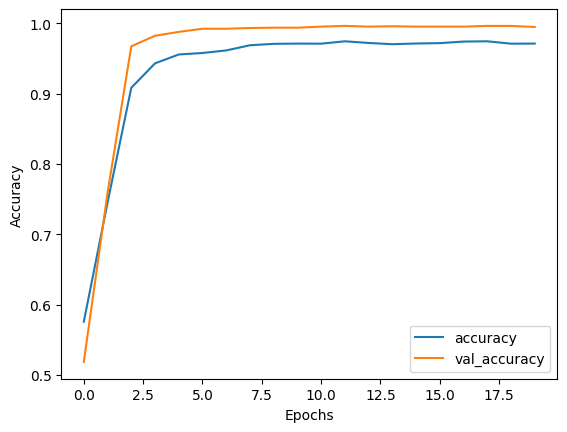

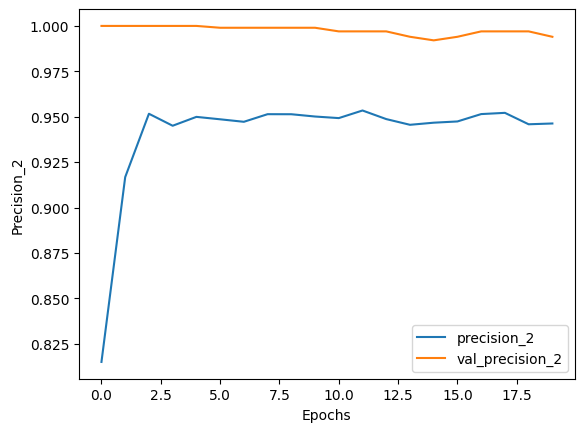

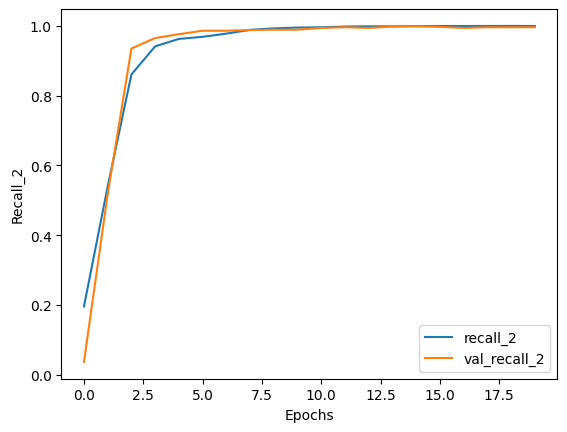

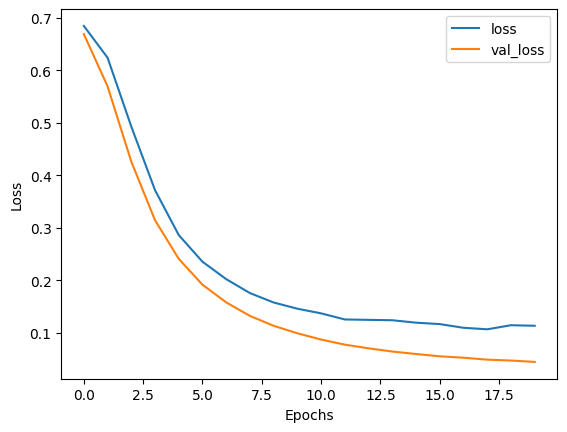

In [45]:
def plot_metrics(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history[f'val_{metric}'])
    plt.xlabel("Epochs")
    plt.ylabel(metric.title())
    plt.legend([metric, f'val_{metric}'])
    plt.show()

plot_metrics(history, "accuracy")
plot_metrics(history, "precision_2")
plot_metrics(history, "recall_2")
plot_metrics(history, "loss")

In [46]:
# Prepare an example with 10 positive and 10 negative tweets.
example_for_prediction = np.append(val_x_prepared[0:10], val_x_prepared[-10:], axis=0)

# Make a prediction on the tweets.
model.predict(example_for_prediction)

1/1 [==============================] - 0s 88ms/step


array([[0.6626793 ],
       [0.933871  ],
       [0.933871  ],
       [0.9200696 ],
       [0.933871  ],
       [0.933871  ],
       [0.933871  ],
       [0.933871  ],
       [0.933871  ],
       [0.933871  ],
       [0.00185563],
       [0.0059999 ],
       [0.00192309],
       [0.00223195],
       [0.00467993],
       [0.00098501],
       [0.00264916],
       [0.00134849],
       [0.00437777],
       [0.00410814]], dtype=float32)

In [47]:
def get_prediction_from_tweet(tweet, model, vocab, max_len):
    tweet = process_tweet(tweet)
    tweet = padded_sequence(tweet, vocab, max_len)
    tweet = np.array([tweet])

    prediction = model.predict(tweet, verbose=False)

    return prediction[0][0]

In [52]:
unseen_tweet = '@DLAI @NLP_team_dlai OMG!!! what a daaay, wow, wow. This AsSiGnMeNt was gr8.'
unseen_tweet='awesome, fabulous ,love it'
prediction_unseen = get_prediction_from_tweet(unseen_tweet, model, vocab, max_len)
print(f"Model prediction on unseen tweet: {prediction_unseen}")

Model prediction on unseen tweet: 0.8953741788864136


In [49]:
# Get the embedding layer
embeddings_layer = model.layers[0]

# Get the weights of the embedding layer
embeddings = embeddings_layer.get_weights()[0]

print(f"Weights of embedding layer have shape: {embeddings.shape}")

Weights of embedding layer have shape: (9535, 16)


In [50]:
# PCA with two dimensions
pca = PCA(n_components=2)

# Dimensionality reduction of the word embeddings
embeddings_2D = pca.fit_transform(embeddings)

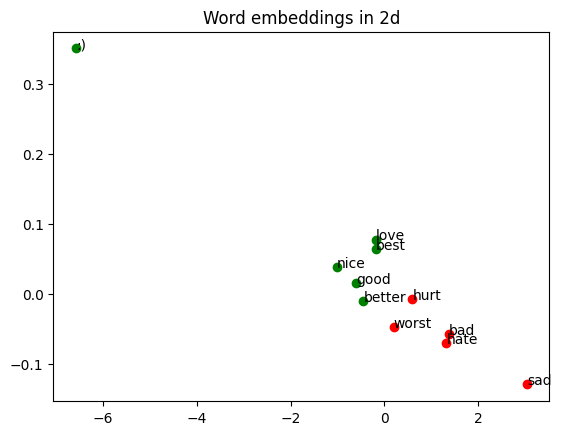

In [51]:
#Selection of negative and positive words
neg_words = ['bad', 'hurt', 'sad', 'hate', 'worst']
pos_words = ['best', 'good', 'nice', 'love', 'better', ':)']

#Index of each selected word
neg_n = [vocab[w] for w in neg_words]
pos_n = [vocab[w] for w in pos_words]

plt.figure()

#Scatter plot for negative words
plt.scatter(embeddings_2D[neg_n][:,0], embeddings_2D[neg_n][:,1], color = 'r')
for i, txt in enumerate(neg_words):
    plt.annotate(txt, (embeddings_2D[neg_n][i,0], embeddings_2D[neg_n][i,1]))

#Scatter plot for positive words
plt.scatter(embeddings_2D[pos_n][:,0], embeddings_2D[pos_n][:,1], color = 'g')
for i, txt in enumerate(pos_words):
    plt.annotate(txt,(embeddings_2D[pos_n][i,0], embeddings_2D[pos_n][i,1]))

plt.title('Word embeddings in 2d')

plt.show()